# Price Prediction Model 

## Authors
| **Name**              | **NIU**   |
|-----------------------|-----------|
| Arnau Muñoz Barrera   | 1665982   |
| José Ortín López      | 1667573   |

## Objective

This project has the objective of creating a machine learning model to predict car prices based on various features. This project is based on the Kaggle Car Price Prediction Challenge dataset from Kaggle.

## Database

To access the source Database: [Link to Database](https://www.kaggle.com/datasets/austinreese/craigslist-carstrucks-data)

## Import Libraries

In [167]:
# install required packages in the notebook environment
%pip install pandas numpy seaborn

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import entropy
from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import LabelEncoder

Note: you may need to restart the kernel to use updated packages.


## Review Initial Structure and Data

In [168]:
df = pd.read_csv('data/vehicles-dataset.csv', engine='python', on_bad_lines='skip')

df.describe(include='all')

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
count,2930,2527,2418,2418,2418,2413,2258,2342,1924,1777,...,1160,1523,1618,2384,2384,0.0,2389,2381.000000,2381.000000,2389
unique,2400,2393,30,30,497,79,38,1014,7,8,...,4,13,12,2081,2144,NaN,4,NaN,NaN,2378
top,;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;,rates as low as 2.99%. ;;;;;;;;;;;;;;;;;;;;;...,new york city,https://newyork.craigslist.org,3500,2008,chevrolet,camry,excellent,6 cylinders,...,full-size,sedan,black,https://images.craigslist.org/00505_he8AibINmZ...,BUY HERE PAY HERE ...,NaN,ny,NaN,NaN,;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;
freq,220,83,445,445,63,180,358,35,843,646,...,641,425,318,7,7,NaN,1883,NaN,NaN,5
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.966901,-75.951059,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.127954,4.900114,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-29.162608,-121.741100,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.778100,-77.651539,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.605600,-74.011459,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.032056,-73.524000,NaN


##### Determine columns & their types

In [169]:
print("[INFO] Dataset columns & their types: \n", df.dtypes)

[INFO] Dataset columns & their types: 
 id               object
url              object
region           object
region_url       object
price            object
year             object
manufacturer     object
model            object
condition        object
cylinders        object
fuel             object
odometer         object
title_status     object
transmission     object
VIN              object
drive            object
size             object
type             object
paint_color      object
image_url        object
description      object
county          float64
state            object
lat             float64
long            float64
posting_date     object
dtype: object


##### Determine quantity of NaNs

[INFO] Does the dataset have missing values? Yes

 [INFO] Percentage of missing values per column: 
 id              0.000000
url             0.001375
region          0.001747
region_url      0.001747
price           0.001747
year            0.001765
fuel            0.001765
odometer        0.001765
transmission    0.001765
title_status    0.001765
posting_date    0.001846
state           0.001846
image_url       0.001863
description     0.001863
lat             0.001874
long            0.001874
model           0.002007
manufacturer    0.002294
condition       0.003433
cylinders       0.003935
drive           0.004389
paint_color     0.004478
type            0.004802
size            0.006041
VIN             0.008870
county          0.010000
dtype: float64


C:\Users\arnau\AppData\Local\Temp\ipykernel_22612\31824092.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Percentage", y="Field", data=df_missing, palette="viridis")


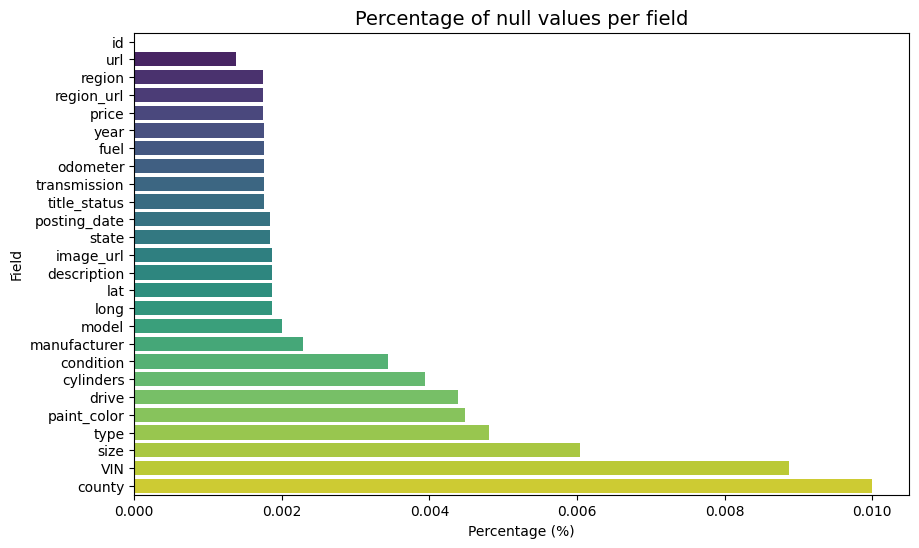

In [170]:
# Auxiliar function to display missing values
def has_nans(df):
    return df.isna().sum().sum() > 0

# Auxiliar function to display percentage of missing values per column
def get_percentage_nan_per_column(df):
    return ((df.isna().sum().sort_values()) / (len(df) * 100))

print("[INFO] Does the dataset have missing values?", "Yes" if has_nans(df) else "No")

if has_nans(df):
    print("\n [INFO] Percentage of missing values per column: \n", get_percentage_nan_per_column(df))

    df_missing = pd.DataFrame(list(get_percentage_nan_per_column(df).items()), columns=["Field", "Percentage"])

    plt.figure(figsize=(10,6))
    sns.barplot(x="Percentage", y="Field", data=df_missing, palette="viridis")

    plt.title("Percentage of null values per field", fontsize=14)
    plt.xlabel("Percentage (%)")
    plt.ylabel("Field")

    plt.show()
else:
    print("\n [INFO] No missing values detected in the dataset.")

### Conclusions

As we can see in previous results, the main initial factors that should be revised & look into are:

| **Problem description**                                | **Proposed Solution**      | **Affected fields**      |
|--------------------------------------------------------|----------------------------|--------------------------|
| Fields with different types or inconsistent ranges     | Normalization & Preprocessing             | **Dataframe**            |
| Field that needs format clean-up                       | Field modifications        | **posting_date**         |
| Field with most NaN values                             | Erase column               | **county**, **VIN**      |
| Field that needs change of type                        | Type modification          | **price**                |

### Clean Up ***Posting_date*** 


In [171]:
df["posting_date"] = df["posting_date"].str.replace(";", "", regex=False)

print("[INFO] Posting date field after cleaning: \n", df['posting_date'].head())

[INFO] Posting date field after cleaning: 
 0    2021-04-13T09:59:51-0400
1    2021-04-12T16:40:04-0400
2    2021-04-12T16:30:35-0400
3    2021-04-12T16:25:04-0400
4    2021-04-12T16:19:55-0400
Name: posting_date, dtype: object


### Normalization & Preprocessing 

In [172]:
# Fields to use: region, year, manufacturer, model, condition, cylinders, fuel, odometer, transmission, drive, size, type, paint_color

# Region
le = LabelEncoder()

df["region"] = le.fit_transform(df["region"])
print("[INFO] New regions: \n", df["region"])

# Year no need to change
# Manufacturer
df["manufacturer"] = le.fit_transform(df["manufacturer"])
print("[INFO] New manufacturer: \n", df["manufacturer"])

# Model
df["model"] = le.fit_transform(df["model"])
print("[INFO] New model: \n", df["model"])

# Condition
df["condition"] = le.fit_transform(df["condition"])
print("[INFO] New condition: \n", df["condition"])

# Cylinders
df["cylinders"] = le.fit_transform(df["cylinders"])
print("[INFO] New cylinders: \n", df["cylinders"])

# Fuel
df["fuel"] = le.fit_transform(df["fuel"])
print("[INFO] New fuel: \n", df["fuel"])

# Odometer (miles traveled) no need to change
# Transmission
df["transmission"] = le.fit_transform(df["transmission"])
print("[INFO] New transmission: \n", df["transmission"])

# Drive (tracción: trasera, delantera)
df["drive"] = le.fit_transform(df["drive"])
print("[INFO] New drive: \n", df["drive"])

# Size
df["size"] = le.fit_transform(df["size"])
print("[INFO] New size: \n", df["size"])

# Type
df["type"] = le.fit_transform(df["type"])
print("[INFO] New type: \n", df["type"])

# Paint_color
df["paint_color"] = le.fit_transform(df["paint_color"])
print("[INFO] New paint_color: \n", df["paint_color"])

[INFO] New regions: 
 0        2
1        2
2        2
3        2
4        2
        ..
2925    11
2926    11
2927    11
2928    11
2929    11
Name: region, Length: 2930, dtype: int64
[INFO] New manufacturer: 
 0        6
1       18
2       10
3        6
4       10
        ..
2925    10
2926    35
2927    35
2928    10
2929    39
Name: manufacturer, Length: 2930, dtype: int64
[INFO] New model: 
 0       249
1       864
2       436
3       923
4       436
       ... 
2925    429
2926    825
2927    828
2928    487
2929    128
Name: model, Length: 2930, dtype: int64
[INFO] New condition: 
 0       1
1       1
2       1
3       1
4       1
       ..
2925    1
2926    2
2927    3
2928    3
2929    3
Name: condition, Length: 2930, dtype: int64
[INFO] New cylinders: 
 0       6
1       5
2       5
3       5
4       5
       ..
2925    5
2926    9
2927    5
2928    5
2929    6
Name: cylinders, Length: 2930, dtype: int64
[INFO] New fuel: 
 0       3
1       3
2       3
3       3
4       3
    

### Erase ***County*** & ***VIN***

In [173]:
df = df.drop(['county', 'VIN'], axis=1)
df.describe(include='all')

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,drive,size,type,paint_color,image_url,description,state,lat,long,posting_date
count,2930,2527,2930.000000,2418,2418,2413,2930.000000,2930.000000,2930.000000,2930.000000,...,2930.000000,2930.000000,2930.000000,2930.000000,2384,2384,2389,2381.000000,2381.000000,2389
unique,2400,2393,NaN,30,497,79,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2081,2144,4,NaN,NaN,2377
top,;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;,rates as low as 2.99%. ;;;;;;;;;;;;;;;;;;;;;...,NaN,https://newyork.craigslist.org,3500,2008,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,https://images.craigslist.org/00505_he8AibINmZ...,BUY HERE PAY HERE ...,ny,NaN,NaN,
freq,220,83,NaN,445,63,180,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,7,7,1883,NaN,NaN,5
mean,NaN,NaN,18.545734,NaN,NaN,NaN,21.264505,617.904437,4.007850,6.044369,...,1.950512,3.321843,9.433447,8.522184,NaN,NaN,NaN,41.966901,-75.951059,NaN
std,NaN,NaN,8.457803,NaN,NaN,NaN,13.278204,322.332800,2.726701,2.314488,...,1.578472,1.783761,5.023860,4.690454,NaN,NaN,NaN,2.127954,4.900114,NaN
min,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,-29.162608,-121.741100,NaN
25%,NaN,NaN,16.000000,NaN,NaN,NaN,10.000000,331.000000,1.000000,5.000000,...,0.000000,1.000000,7.000000,5.000000,NaN,NaN,NaN,40.778100,-77.651539,NaN
50%,NaN,NaN,19.000000,NaN,NaN,NaN,18.000000,639.000000,3.000000,6.000000,...,2.000000,4.000000,11.000000,10.000000,NaN,NaN,NaN,41.605600,-74.011459,NaN
75%,NaN,NaN,25.000000,NaN,NaN,NaN,36.000000,939.750000,7.000000,8.000000,...,4.000000,5.000000,14.000000,13.000000,NaN,NaN,NaN,43.032056,-73.524000,NaN


### Modify type of ***Price***

In [174]:
df["price"] = pd.to_numeric(df["price"], errors="coerce")

print("[INFO] Price field after conversion to numeric: \n", df['price'].head())

[INFO] Price field after conversion to numeric: 
 0    22000.0
1     8250.0
2     6850.0
3     6250.0
4     4250.0
Name: price, dtype: float64


##### Analysis of correlations with **target**: '***Price***'

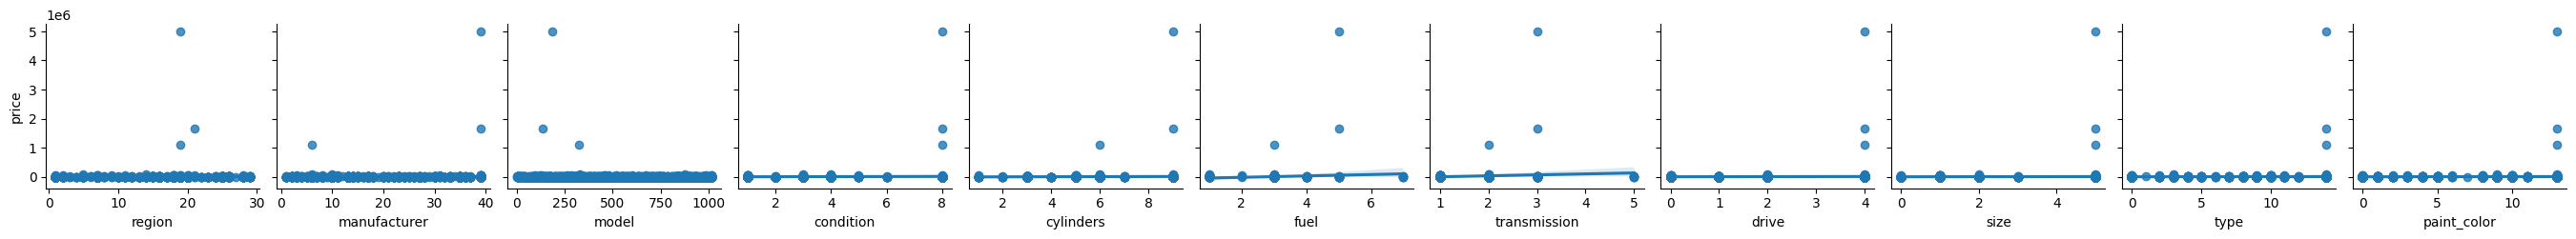

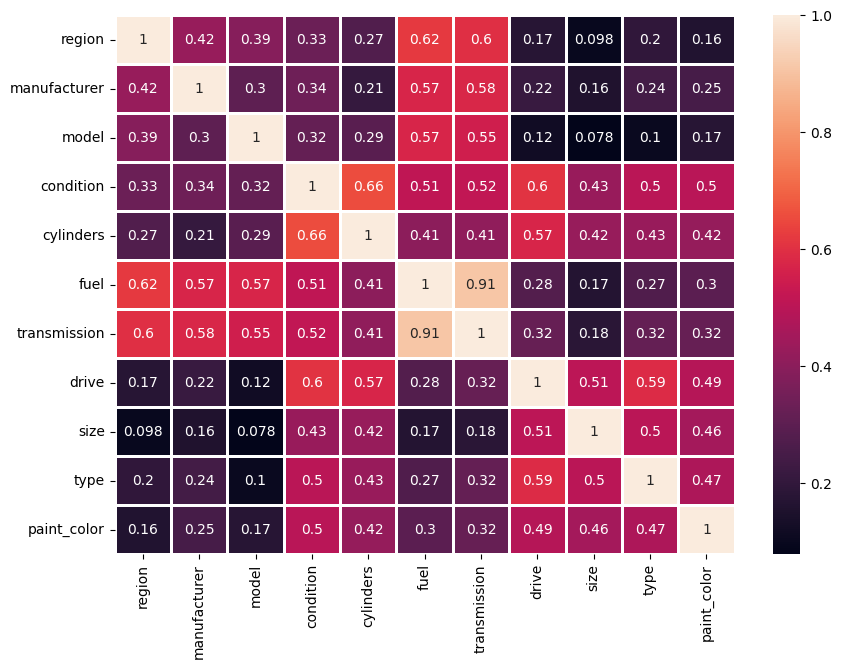

In [175]:
# Fields to use: region, year, manufacturer, model, condition, cylinders, fuel, odometer, transmission, drive, size, type, paint_color
cols = ["region", "year", "manufacturer", "model", "condition", "cylinders",
        "fuel", "odometer", "transmission", "drive", "size", "type", "paint_color"]

numeric_cols = df[cols].select_dtypes(include=["number"]).columns.tolist()

sns.pairplot(
    df,
    y_vars=["price"],
    x_vars=numeric_cols,
    kind="reg",
    dropna=True
)

# Correlation heatmap

plt.figure(figsize=(10, 7))

# DataFrame solo con columnas numéricas seleccionadas
corr = df[numeric_cols].corr()

sns.heatmap(
    corr,
    annot=True,
    linewidths=2
)
plt.show()


##### ☣️ Is the data balanced?

In [176]:
entropies= df.apply(lambda col: entropy(col.value_counts(normalize=True), base=2)/np.log2(col.nunique()))
entropies

id              0.919724
url             0.979990
region          0.750342
region_url      0.752919
price           0.879994
year            0.762533
manufacturer    0.805210
model           0.821471
condition       0.797864
cylinders       0.748588
fuel            0.353638
odometer        0.907088
title_status    0.146485
transmission    0.469471
drive           0.965344
size            0.806878
type            0.760325
paint_color     0.802550
image_url       0.990680
description     0.992570
state           0.521134
lat             0.927228
long            0.927078
posting_date    0.999589
dtype: float64

## Metric Selection

In this section, we will focus on selecting the appropriate classification metrics and mechanisms to analyze the performance of our final model. To do so, we will train our data using logistic regression and generate a set of functions to evaluate the results, such as graphical functions (Precision-Recall Curve and ROC Curve).

The metrics we are going to analyze are the following: Mean Squared Error (MSE), Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), Coefficient of Determination (R²). Once we obtain the results and functions, we will decide which metric to use in order to select the best-performing model.

In [177]:
# Declaration of functions to analyze the metrics:
def calculMetriques(y_true, y_pred, metric='mse'):
    if metric == 'mse':
        result = mean_squared_error(y_true,y_pred)
    elif metric == 'rmse':
        result = np.sqrt(mean_squared_error(y_true,y_pred))
    elif metric == 'mae':
        result = mean_absolute_error(y_true,y_pred)
    elif metric == 'r2':
        result = r2_score(y_true,y_pred)
    else:
        raise ValueError("Métrica no reconocida")

    return result

In [178]:
def mostrar_grafics (y, y_pred):
    # Scatter plot between real values (y) and predicted values (y_pred)
    plt.scatter(y,y_pred)
    # Add a red line representing the ideal line (y = y_pred)
    plt.plot(y,y,'--',c = 'red')
    plt.xlabel('y_real') # Label for the X-axis
    plt.ylabel('y_pred') # Label for the Y-axis
    plt.show()           # Display the plot

    # Scatter plot of the errors (difference between y_pred and y)
    plt.scatter(y,y_pred-y)
    plt.xlabel('y_real') 
    plt.ylabel('error')  # Label for the Y-axis (error)
    plt.show()

    # Scatter plot of the absolute error (MAE) for each y value
    plt.scatter(y,abs(y_pred-y))
    plt.xlabel('y_real') 
    plt.ylabel('MAE')    # Label for the X-axis (Mean Absolute Error)
    plt.show()

    # Gràfic de dispersió del MAPE (error absolut relatiu per cada valor de y)
    plt.scatter(y,abs(y_pred-y)/y)
    plt.xlabel('y_real') 
    plt.ylabel('MAPE')   # Label for the X-axis (Mean Absolute Percentage Error)
    plt.show()

In [179]:
### MODEL TRAINING #####
# Split X and Y
target_att = 'price'
attributes = [k for k in df.keys() if k!= target_att]
X = df[attributes]
y = df[[target_att]]

lr = LinearRegression(fit_intercept = True)
lr.fit(X,y)

# Evaluate the model performance
y_pred = lr.predict(X)

# Call to the metric calculation function
print("Mètriques: \n")
print(" Mean Squared Error (MSE):", calculMetriques(y,y_pred, metric="mse"))
print(" Root Mean Squared Error (RMSE):", calculMetriques(y,y_pred, metric="rmse"))
print(" Mean Absolute Error (MAE):", calculMetriques(y,y_pred, metric="mae"))
print(" Coefficient of Determination (R²):", calculMetriques(y,y_pred, metric="r2"))

# Call to the plot generation function
mostrar_grafics(y, y_pred)

ValueError: could not convert string to float: ' TRADE IN OR PAYOFF ANYTIME'

Un cop analitzats els resultats amb les diferents mètriques i mecanismes escollirem quina mètrica utilitzarem per avaluar els rendiments dels models i escollir el que més s'adapta al nostre dataset.

##### Mètriques escollides per avaluar el nostre model
* **Mean Squared Error (MSE)**:

    Mesura l'error quadràtic mitjà entre els valors reals i els predits

    Ens aporta informació sobre com de grans són els errors, penalitzant especialment els errors grans. També ens dona una idea general de la precisió del model.

    $MSE=\frac{1}{m}\sum_{i=1}^{m}(y_i-\hat{y}_i)^2$

    <span style="color: red;">✗ *Mètrica no escollida*</span>

* **Root Mean Squared Error (RMSE)**:
    Arrel quadrada del MSE.

    Ens aporta informació de quants euros ens equivoquem de mitjana en les prediccions. És una mètrica útil perquè ens aporta una visió global del rendiment.

    $RMSE=\sqrt{MSE}$

    <span style="color: red;">✗ *Mètrica no escollida*</span>

* **Mean Absolute Error (MAE)**:
    Calcula l'error mitjà en valor absolut
    
    Ens aporta informació de quant s'equivoca el model de mitjana en valor absolut. A diferència del MSE, no penalitza en excés els outliers. Es una mètrica de gran utilitat quan volem tenir una mesura concreta del comportament global del model sense que els errors molt grans afectin a la mètrica

    $MAE=\frac{1}{m}\sum_{i=1}^{m}\lvert y_i-\hat{y}_i\rvert$

    <span style="color: green;">✔ *Mètrica escollida*</span>

* **Coefficient of Determination (R²)**:
    Percentatge de la variabilitat del preu és explicat pel model

    Ens aporta informació sobre com de bé el model explica l'estructura del dataset. Quan ens trobem amb un R² baix significa que el model no es capaç de capturar la relació entre les variables d'entrades i la variable target (preu). En canvi, quan tenim un R² gran el model es capaç de justificar les variacions en els preus.Es una mètrica de gran utilitat per comparar models amb diferents complexitats 
    


    $R^2 = 1-\frac{\sum_{i=1}^{m}(y_i-\hat{y}i)^2}{\sum{i=1}^{m}(y_i-\bar{y})^2}$
    
    on $\bar{y}$ és la mitjana dels valors reals

    <span style="color: red;">✗ *Mètrica no escollida*</span>